In [1]:
from google.colab import files
uploaded = files.upload()

Saving AEP_hourly.csv to AEP_hourly.csv


Long Short Term Memory (LSTM)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [3]:
# 1. Load Dataset
df = pd.read_csv("AEP_hourly.csv", parse_dates=['Datetime'])
df.sort_values("Datetime", inplace=True)
df.set_index("Datetime", inplace=True)

In [4]:
# 2. Ubah ke data harian (menjumlahkan konsumsi tiap hari)
df_daily = df.resample('D').sum()

In [47]:
df_daily = df_daily[:-1]
df_daily

,AEP_MW
Datetime,
2004-10-01,328544.0
2004-10-02,311997.0
2004-10-03,293450.0
2004-10-04,343417.0
2004-10-05,346553.0
...,...
2018-07-29,327792.0
2018-07-30,368834.0
2018-07-31,364327.0


In [48]:
# 3. Membagi Train dan Test
train = df_daily[df_daily.index < '2014-01-01']
test = df_daily[df_daily.index >= '2014-01-01']

In [49]:
# 4. Normalisasi
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['AEP_MW']])
test_scaled = scaler.transform(test[['AEP_MW']])

In [50]:
# 5. Fungsi membuat sequence data
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

In [51]:
# Buat data sequence untuk training dan testing
time_steps = 30
X_train, y_train = create_sequences(train_scaled, time_steps)
X_test, y_test = create_sequences(test_scaled, time_steps)
# Timesteps 30 -> melihat data 30 hari sebelumnya untuk memprediksi 1 hari

# Ubah shape ke 3D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# menyesuaikan format input yang dibutuhkan oleh model LSTM di TensorFlow/Keras.

In [52]:
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
# 50 unit neuron

model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0338
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0134
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0119
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0116
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0090
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0076
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0073
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0069
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0072
Epoch 10/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0066
Epoch 11/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0063
Epoch 12/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0063
Epoch 13/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0051
Epoch 14/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0050
Epoch 15/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step 

In [53]:
predicted = model.predict(X_test)

# Balikkan skala ke nilai asli
predicted_unscaled = scaler.inverse_transform(predicted)
y_test_unscaled = scaler.inverse_transform(y_test)

# Hitung RMSE
rmse = sqrt(mean_squared_error(y_test_unscaled, predicted_unscaled))
print("RMSE LSTM:", rmse)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE LSTM: 18209.045827217178


In [54]:
print("Model Performance Summary")
print(f"RMSE LSTM: {rmse:.2f} MW")
print(f"Persentase Error: {(rmse / y_test_unscaled.mean()) * 100:.2f}% dari rata-rata konsumsi harian")

Model Performance Summary
RMSE LSTM: 18209.05 MW
Persentase Error: 5.12% dari rata-rata konsumsi harian


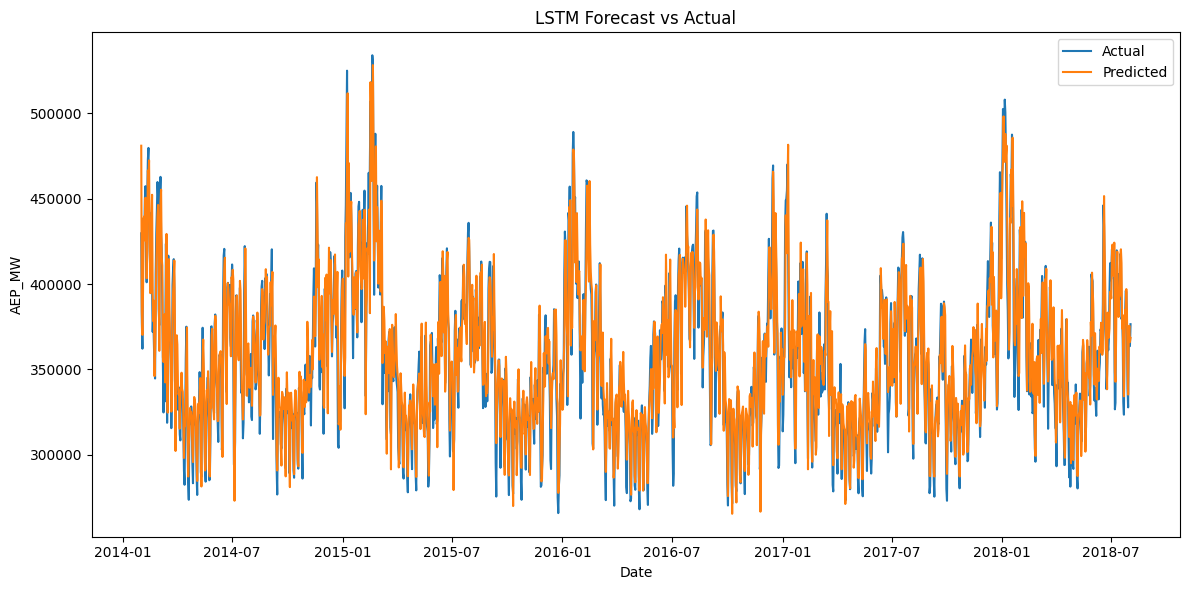

In [55]:
plt.figure(figsize=(12,6))
plt.plot(test.index[time_steps:], y_test_unscaled, label='Actual')
plt.plot(test.index[time_steps:], predicted_unscaled, label='Predicted')
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("AEP_MW")
plt.legend()
plt.tight_layout()
plt.show()

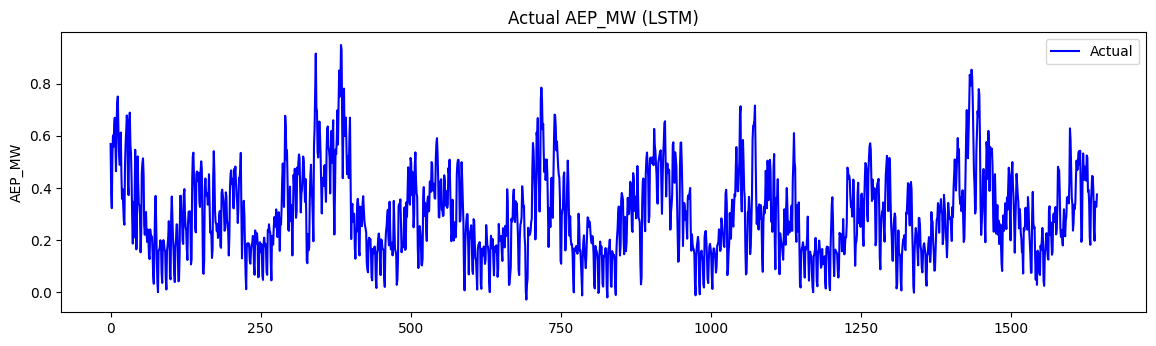

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Subplot 1: Data Aktual
plt.subplot(2, 1, 1)
plt.plot(y_test, label='Actual', color='blue')
plt.title("Actual AEP_MW (LSTM)")
plt.ylabel("AEP_MW")
plt.legend()

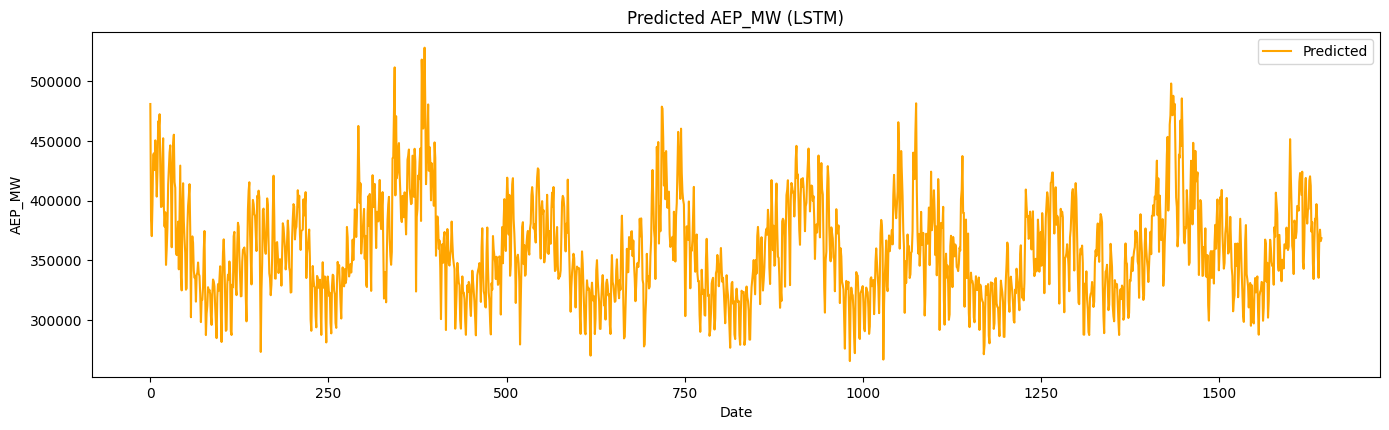

In [57]:
# Subplot 2: Data Prediksi
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 2)
plt.plot(predicted_unscaled, label='Predicted', color='orange')
plt.title("Predicted AEP_MW (LSTM)")
plt.xlabel("Date")
plt.ylabel("AEP_MW")
plt.legend()

plt.tight_layout()
plt.show()

Prediksi 1 Tahun Kedepan

        Date  Predicted AEP_MW
0 2018-08-03      363833.87500
1 2018-08-04      327251.43750
2 2018-08-05      311439.46875
3 2018-08-06      350151.43750
4 2018-08-07      352251.53125
5 2018-08-08      348757.62500
6 2018-08-09      350036.71875
7 2018-08-10      348432.03125
8 2018-08-11      316664.87500
9 2018-08-12      300514.31250


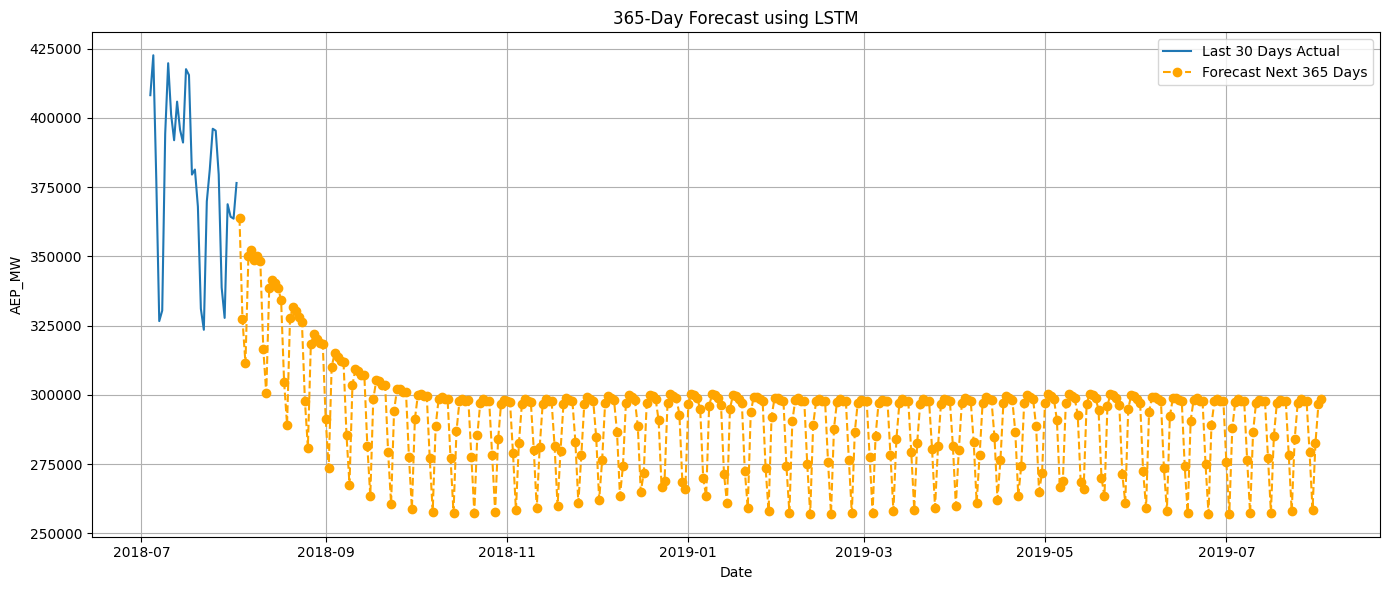

In [86]:
# Ambil 30 hari terakhir dari data harian yang sudah diskalakan
last_30_days = test_scaled[-time_steps:]  # Bentuk (30, 1)

# Buat prediksi untuk 365 hari ke depan secara autoregresif
future_predictions = []
current_input = last_30_days.copy()

for _ in range(365):
    # Ubah ke bentuk 3D (1, 30, 1)
    input_reshaped = current_input.reshape((1, time_steps, 1))

    # Prediksi 1 langkah ke depan
    pred = model.predict(input_reshaped, verbose=0)

    # Simpan hasil prediksi
    future_predictions.append(pred[0][0])

    # Geser window input (buang yang paling lama, tambahkan yang terbaru)
    current_input = np.append(current_input[1:], [[pred[0][0]]], axis=0)

# Kembalikan hasil ke skala asli
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Buat range tanggal untuk 365 hari ke depan
last_date = test.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365)

# Buat dataframe hasil prediksi
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted AEP_MW': future_predictions_unscaled.flatten()
})

# Tampilkan sebagian hasil (misalnya 10 hari pertama)
print(forecast_df.head(10))

# Plot hasil prediksi 365 hari ke depan
plt.figure(figsize=(14, 6))
plt.plot(test.index[-30:], test['AEP_MW'].values[-30:], label='Last 30 Days Actual')
plt.plot(forecast_df['Date'], forecast_df['Predicted AEP_MW'], linestyle='--', color='orange', label='Forecast Next 365 Days')
plt.title('365-Day Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('AEP_MW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


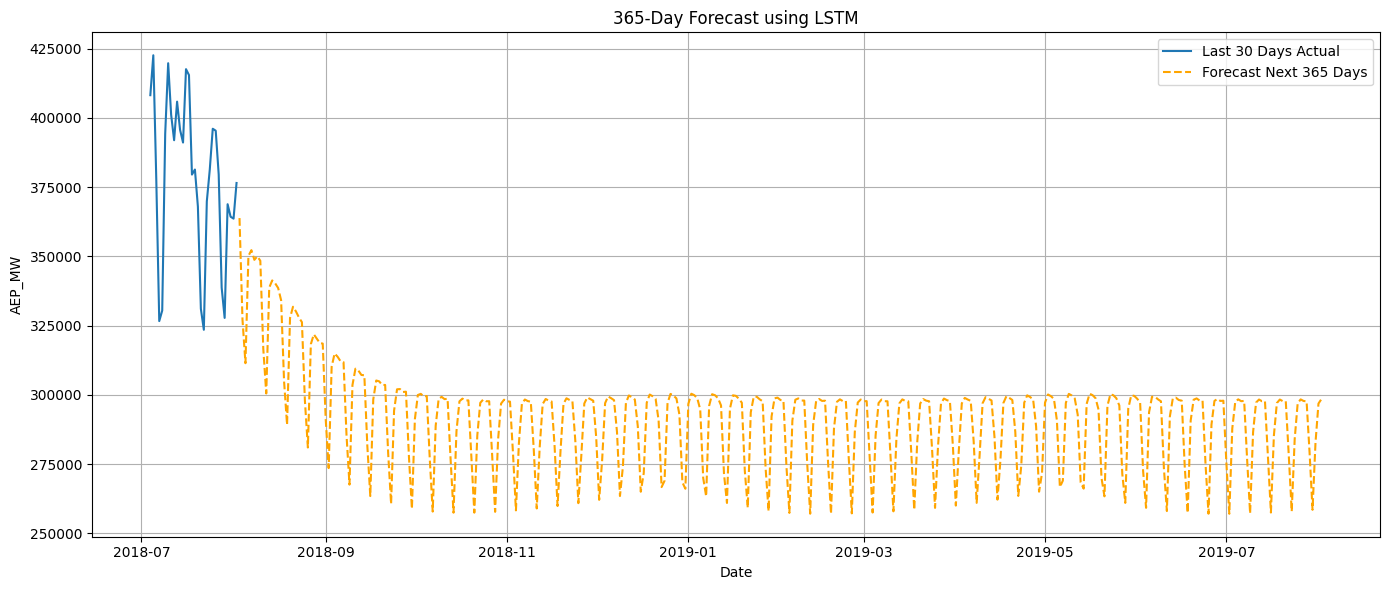

In [87]:
# Plot hasil prediksi 365 hari ke depan
plt.figure(figsize=(14, 6))
plt.plot(test.index[-30:], test['AEP_MW'].values[-30:], label='Last 30 Days Actual')
plt.plot(forecast_df['Date'], forecast_df['Predicted AEP_MW'], linestyle='--', color='orange', label='Forecast Next 365 Days')
plt.title('365-Day Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('AEP_MW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Prediksi 1 Bulan

Prediksi Konsumsi Listrik 30 Hari ke Depan:
         Date  Predicted AEP_MW
0  2018-08-03      363833.87500
1  2018-08-04      327251.43750
2  2018-08-05      311439.46875
3  2018-08-06      350151.43750
4  2018-08-07      352251.53125
5  2018-08-08      348757.62500
6  2018-08-09      350036.71875
7  2018-08-10      348432.03125
8  2018-08-11      316664.87500
9  2018-08-12      300514.31250
10 2018-08-13      338727.43750
11 2018-08-14      341316.53125
12 2018-08-15      340283.75000
13 2018-08-16      338587.25000
14 2018-08-17      334165.68750
15 2018-08-18      304792.06250
16 2018-08-19      289184.75000
17 2018-08-20      327776.28125
18 2018-08-21      331826.18750
19 2018-08-22      330110.65625
20 2018-08-23      327943.46875
21 2018-08-24      326253.65625
22 2018-08-25      297947.53125
23 2018-08-26      281003.81250
24 2018-08-27      318308.15625
25 2018-08-28      321854.21875
26 2018-08-29      320300.90625
27 2018-08-30      318758.71875
28 2018-08-31      318515.75

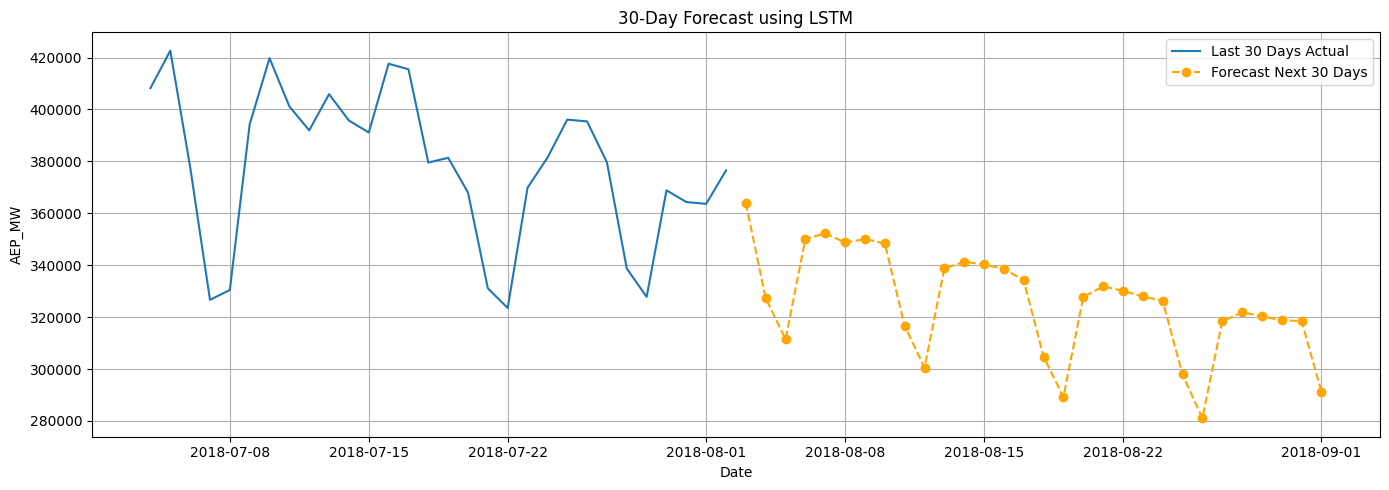

In [103]:
# Ambil 30 hari terakhir dari data harian yang sudah diskalakan
last_30_days = test_scaled[-time_steps:]  # Bentuk (30, 1)

# Buat prediksi untuk 30 hari ke depan secara autoregresif
future_predictions = []
current_input = last_30_days.copy()

for _ in range(30):  # Ganti ke 30 untuk 1 bulan
    input_reshaped = current_input.reshape((1, time_steps, 1))
    pred = model.predict(input_reshaped, verbose=0)
    future_predictions.append(pred[0][0])
    current_input = np.append(current_input[1:], [[pred[0][0]]], axis=0)

# Kembalikan hasil ke skala asli
future_predictions_unscaled = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Buat range tanggal untuk 30 hari ke depan
last_date = test.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Buat dataframe hasil prediksi
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted AEP_MW': future_predictions_unscaled.flatten()
})

# Tampilkan hasil prediksi
print("Prediksi Konsumsi Listrik 30 Hari ke Depan:")
print(forecast_df)

# Plot hasil prediksi
plt.figure(figsize=(14, 5))
plt.plot(test.index[-30:], test['AEP_MW'].values[-30:], label='Last 30 Days Actual')
plt.plot(forecast_df['Date'], forecast_df['Predicted AEP_MW'], marker='o', linestyle='--', color='orange', label='Forecast Next 30 Days')
plt.title('30-Day Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('AEP_MW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [104]:
# Tambahkan kolom "Day" untuk menunjukkan hari dalam minggu
forecast_df['Day'] = forecast_df['Date'].dt.strftime('%A')

# Tampilkan hasil prediksi beserta nama harinya
print("Prediksi Konsumsi Listrik 30 Hari ke Depan (dengan Hari):")
print(forecast_df)


Prediksi Konsumsi Listrik 30 Hari ke Depan (dengan Hari):
         Date  Predicted AEP_MW        Day
0  2018-08-03      363833.87500     Friday
1  2018-08-04      327251.43750   Saturday
2  2018-08-05      311439.46875     Sunday
3  2018-08-06      350151.43750     Monday
4  2018-08-07      352251.53125    Tuesday
5  2018-08-08      348757.62500  Wednesday
6  2018-08-09      350036.71875   Thursday
7  2018-08-10      348432.03125     Friday
8  2018-08-11      316664.87500   Saturday
9  2018-08-12      300514.31250     Sunday
10 2018-08-13      338727.43750     Monday
11 2018-08-14      341316.53125    Tuesday
12 2018-08-15      340283.75000  Wednesday
13 2018-08-16      338587.25000   Thursday
14 2018-08-17      334165.68750     Friday
15 2018-08-18      304792.06250   Saturday
16 2018-08-19      289184.75000     Sunday
17 2018-08-20      327776.28125     Monday
18 2018-08-21      331826.18750    Tuesday
19 2018-08-22      330110.65625  Wednesday
20 2018-08-23      327943.46875   Thurs

Melihat Data Prediksi 30 Hari

In [106]:
print(forecast_df[['Date', 'Predicted AEP_MW']].head(10))

        Date  Predicted AEP_MW
0 2018-08-03      363833.87500
1 2018-08-04      327251.43750
2 2018-08-05      311439.46875
3 2018-08-06      350151.43750
4 2018-08-07      352251.53125
5 2018-08-08      348757.62500
6 2018-08-09      350036.71875
7 2018-08-10      348432.03125
8 2018-08-11      316664.87500
9 2018-08-12      300514.31250


In [107]:
# Tambahkan kolom 'Day' jika belum ada
forecast_df['Day'] = forecast_df['Date'].dt.strftime('%A')

# Cek apakah berhasil
print(forecast_df[['Date', 'Day']].head())


        Date       Day
0 2018-08-03    Friday
1 2018-08-04  Saturday
2 2018-08-05    Sunday
3 2018-08-06    Monday
4 2018-08-07   Tuesday


/tmp/ipython-input-110-1875099173.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_summary.index, y=day_summary.values, palette='viridis')


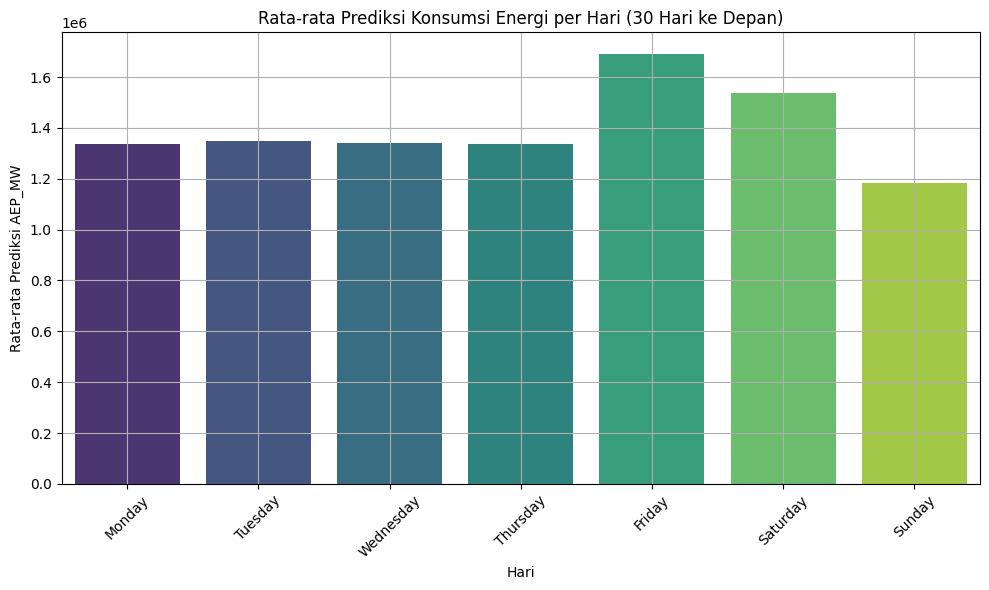

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tentukan urutan hari agar plot-nya rapi
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Hitung rata-rata
day_summary = forecast_df.groupby('Day', observed=True)['Predicted AEP_MW'].sum().reindex(day_order)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=day_summary.index, y=day_summary.values, palette='viridis')
plt.title('Rata-rata Prediksi Konsumsi Energi per Hari (30 Hari ke Depan)')
plt.xlabel('Hari')
plt.ylabel('Rata-rata Prediksi AEP_MW')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


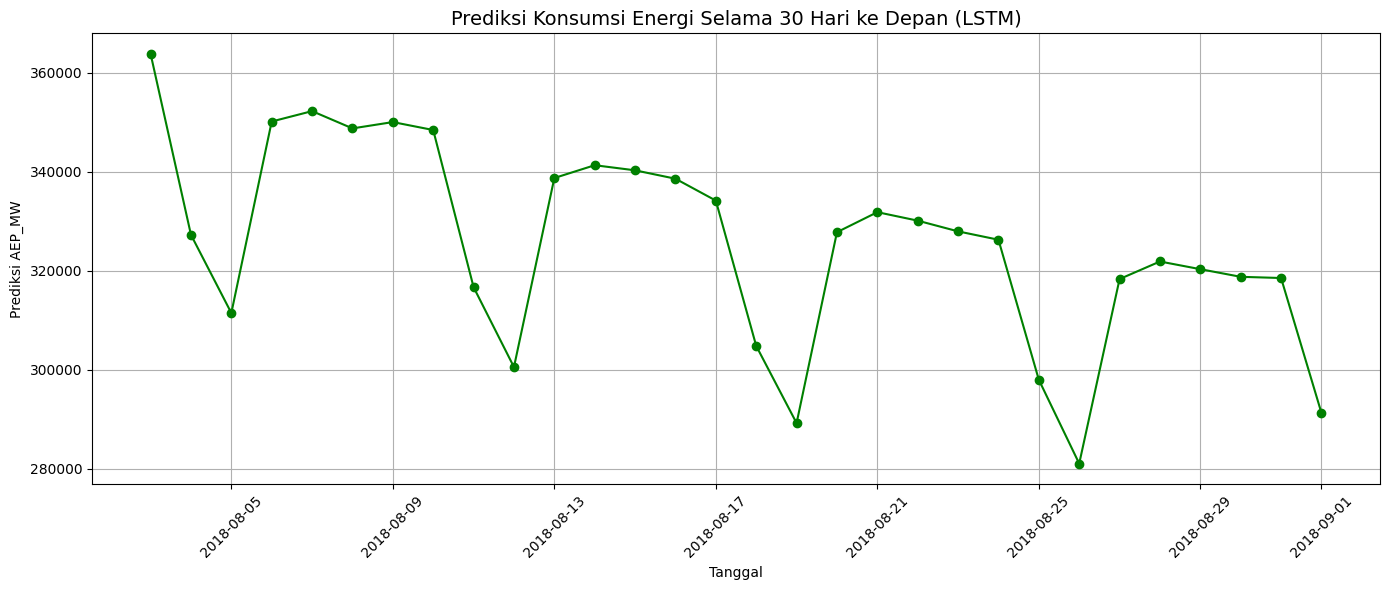

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(forecast_df['Date'], forecast_df['Predicted AEP_MW'], marker='o', linestyle='-', color='green')
plt.title('Prediksi Konsumsi Energi Selama 30 Hari ke Depan (LSTM)', fontsize=14)
plt.xlabel('Tanggal')
plt.ylabel('Prediksi AEP_MW')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-113-2618161088.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Day', y='Predicted AEP_MW', data=forecast_df, estimator='mean', ci=None)


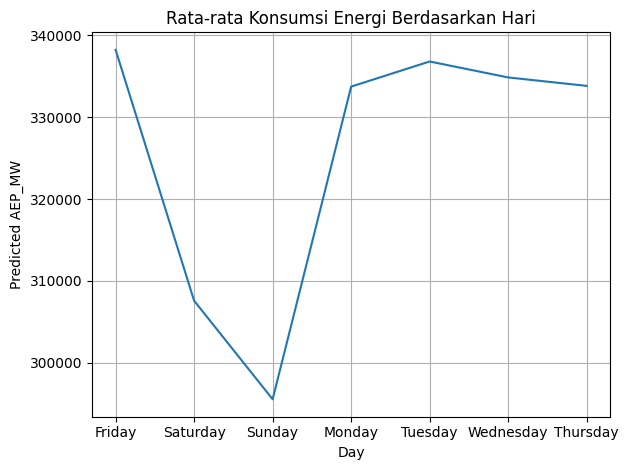

In [113]:
sns.lineplot(x='Day', y='Predicted AEP_MW', data=forecast_df, estimator='mean', ci=None)
plt.title("Rata-rata Konsumsi Energi Berdasarkan Hari")
plt.ylabel("Predicted AEP_MW")
plt.grid(True)
plt.tight_layout()
plt.show()


Prediksi Per Jam Selama 30 Hari

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3789/3789 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 0.0062
Epoch 2/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - loss: 3.5457e-04
Epoch 3/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 2.9583e-04
Epoch 4/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 2.4876e-04
Epoch 5/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 2.1930e-04
Epoch 6/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 1.9169e-04
Epoch 7/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 1.8168e-04
Epoch 8/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 1.8388e-04
Epoch 9/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - loss: 1.6812e-04
Epoch 10/10
3789/3789 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 1.6832e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/st

/tmp/ipython-input-114-39719012.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(start=cutoff_date, periods=720, freq='H')


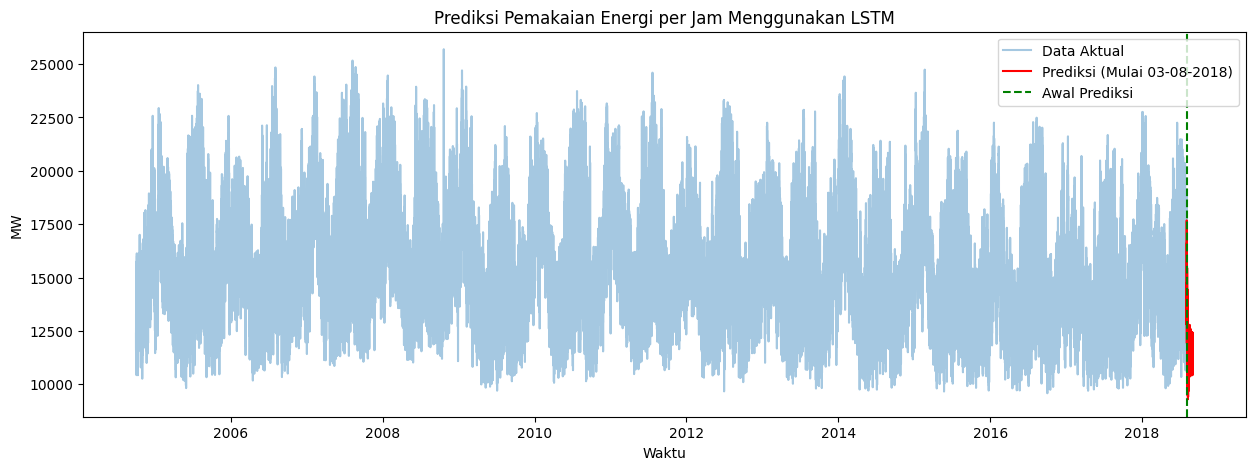

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import timedelta

# 1. Load data
df = pd.read_csv("AEP_hourly.csv", parse_dates=['Datetime'])
df.sort_values("Datetime", inplace=True)
df.set_index("Datetime", inplace=True)

# 2. Filter hanya sampai sebelum 03-08-2018
cutoff_date = '2018-08-03'
df_train = df[df.index < cutoff_date]

# 3. Normalisasi data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train)

# 4. Buat window time series (misal 24 jam sebelumnya → 1 jam prediksi)
def create_sequences(data, window=24):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 24  # 1 hari
X_train, y_train = create_sequences(train_scaled, window=window_size)

# 5. Bangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 6. Latih model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 7. Prediksi 30 hari ke depan (30 hari x 24 jam = 720 jam)
# Mulai dari titik terakhir di training set
future_predictions = []
last_sequence = train_scaled[-window_size:].reshape(1, window_size, 1)

for _ in range(720):  # 720 jam ke depan
    pred = model.predict(last_sequence)[0]
    future_predictions.append(pred)
    last_sequence = np.append(last_sequence[:,1:,:], [[pred]], axis=1)

# 8. Transform kembali ke skala asli
future_predictions = scaler.inverse_transform(future_predictions)

# 9. Buat index waktu untuk hasil prediksi
future_index = pd.date_range(start=cutoff_date, periods=720, freq='H')

# 10. Buat DataFrame hasil prediksi
df_pred = pd.DataFrame(data=future_predictions, index=future_index, columns=['Predicted'])

# 11. Visualisasi hasil prediksi
plt.figure(figsize=(15,5))
plt.plot(df['AEP_MW'], label='Data Aktual', alpha=0.4)
plt.plot(df_pred, label='Prediksi (Mulai 03-08-2018)', color='red')
plt.axvline(pd.to_datetime(cutoff_date), color='green', linestyle='--', label='Awal Prediksi')
plt.title('Prediksi Pemakaian Energi per Jam Menggunakan LSTM')
plt.xlabel('Waktu')
plt.ylabel('MW')
plt.legend()
plt.show()


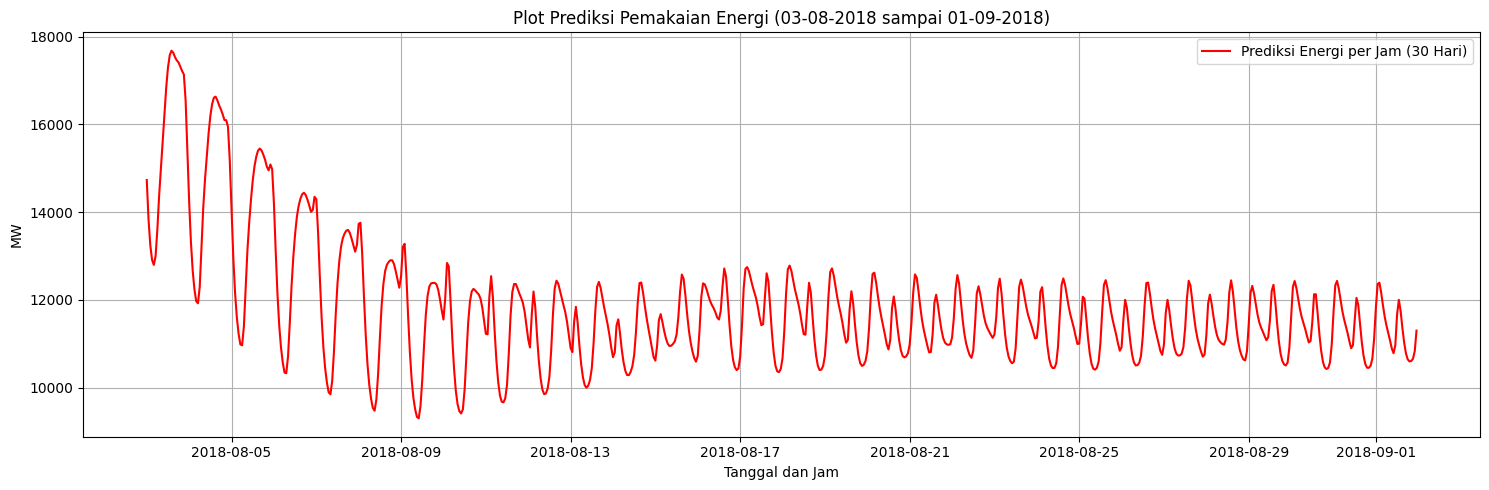

In [115]:
# Visualisasi hanya hasil prediksi selama 30 hari (per jam)
plt.figure(figsize=(15,5))
plt.plot(df_pred, label='Prediksi Energi per Jam (30 Hari)', color='red')
plt.title('Plot Prediksi Pemakaian Energi (03-08-2018 sampai 01-09-2018)')
plt.xlabel('Tanggal dan Jam')
plt.ylabel('MW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


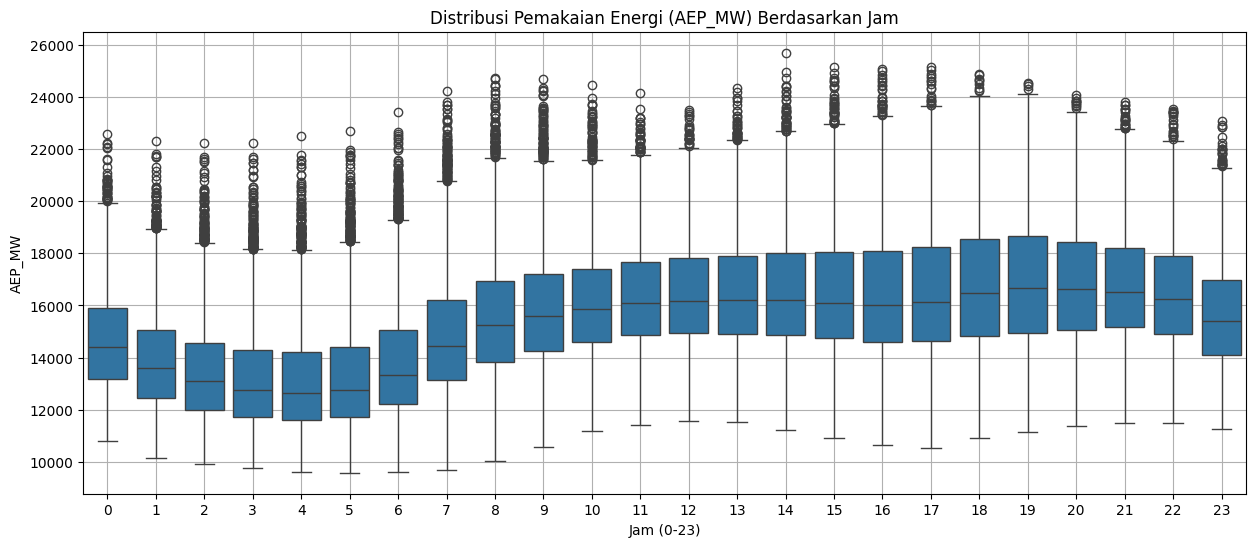

In [116]:
import seaborn as sns

# 1. Tambahkan kolom jam ke DataFrame
df['Hour'] = df.index.hour

# 2. Plot distribusi nilai AEP_MW berdasarkan jam
plt.figure(figsize=(15,6))
sns.boxplot(x='Hour', y='AEP_MW', data=df)
plt.title('Distribusi Pemakaian Energi (AEP_MW) Berdasarkan Jam')
plt.xlabel('Jam (0-23)')
plt.ylabel('AEP_MW')
plt.grid(True)
plt.show()


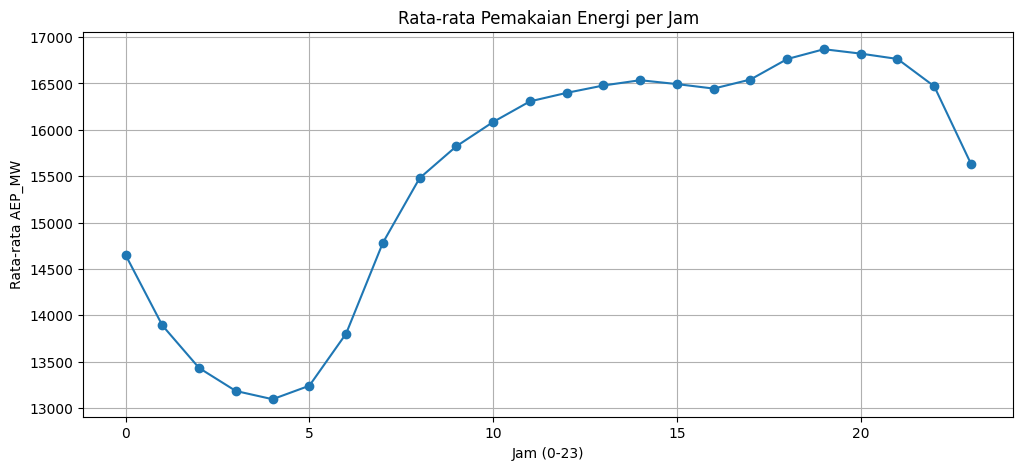

In [117]:
# Rata-rata AEP_MW per jam
avg_per_hour = df.groupby('Hour')['AEP_MW'].mean()

plt.figure(figsize=(12,5))
avg_per_hour.plot(marker='o')
plt.title('Rata-rata Pemakaian Energi per Jam')
plt.xlabel('Jam (0-23)')
plt.ylabel('Rata-rata AEP_MW')
plt.grid(True)
plt.show()

In [118]:
# Menampilkan hasil prediksi per jam selama 30 hari
pd.set_option('display.float_format', '{:,.2f}'.format)  # agar angka lebih rapi
print(df_pred.head(48))  # tampilkan 48 jam pertama (2 hari)

                     Predicted
2018-08-03 00:00:00  14,732.17
2018-08-03 01:00:00  13,828.61
2018-08-03 02:00:00  13,248.68
2018-08-03 03:00:00  12,912.17
2018-08-03 04:00:00  12,797.97
2018-08-03 05:00:00  12,998.91
2018-08-03 06:00:00  13,607.89
2018-08-03 07:00:00  14,376.45
2018-08-03 08:00:00  14,984.06
2018-08-03 09:00:00  15,563.44
2018-08-03 10:00:00  16,217.56
2018-08-03 11:00:00  16,829.23
2018-08-03 12:00:00  17,293.28
2018-08-03 13:00:00  17,575.68
2018-08-03 14:00:00  17,679.26
2018-08-03 15:00:00  17,635.06
2018-08-03 16:00:00  17,531.31
2018-08-03 17:00:00  17,459.37
2018-08-03 18:00:00  17,411.59
2018-08-03 19:00:00  17,311.64
2018-08-03 20:00:00  17,217.37
2018-08-03 21:00:00  17,140.51
2018-08-03 22:00:00  16,548.00
2018-08-03 23:00:00  15,400.44
2018-08-04 00:00:00  14,240.38
2018-08-04 01:00:00  13,323.50
2018-08-04 02:00:00  12,673.11
2018-08-04 03:00:00  12,237.39
2018-08-04 04:00:00  11,971.04
2018-08-04 05:00:00  11,923.60
2018-08-04 06:00:00  12,300.38
2018-08-

In [119]:
print(df_pred)

                     Predicted
2018-08-03 00:00:00  14,732.17
2018-08-03 01:00:00  13,828.61
2018-08-03 02:00:00  13,248.68
2018-08-03 03:00:00  12,912.17
2018-08-03 04:00:00  12,797.97
...                        ...
2018-09-01 19:00:00  10,598.76
2018-09-01 20:00:00  10,608.26
2018-09-01 21:00:00  10,659.00
2018-09-01 22:00:00  10,831.84
2018-09-01 23:00:00  11,301.06

[720 rows x 1 columns]
